rename this file from AE_style_transfer_2 to cinn_style_transfer_inference

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
from autoencoder import AEStyleTransfer

d:\anaconda_neel\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
d:\anaconda_neel\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
d:\anaconda_neel\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
# Get the current working directory
current_directory = os.getcwd()

In [4]:
device='cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Define the relative path to the dataset directory
dataset_directory = os.path.join(current_directory, 'datasets')

# Define the filename
filename = 'autoencoder_mixed_mnist_dropout_0.01_60_epochs.pth'

# Combine the directory path and filename to obtain the full path to the file
PATH_PARAMS_AE_PRETRAINED  = os.path.join(dataset_directory, filename)

In [6]:
# Load the pretrained AE model, trained on uncolored+colored mnist data
pretrained_model_list = torch.load(PATH_PARAMS_AE_PRETRAINED,map_location=torch.device('cpu'))
# this is because the AE was originally trained on GPUs.

# instantiate the model
ae_pretrained= AEStyleTransfer(dropout_prob=0.01)

ae_pretrained.load_state_dict(pretrained_model_list)

<All keys matched successfully>

### Load Encodings

In [7]:
PATH_COLORED_MNIST_TEST= os.path.join(dataset_directory, "encoded_images_ST_test_set.pt")
encoded_image_test_set=  torch.load(PATH_COLORED_MNIST_TEST)

Note that first half of encodings in the train and test set above are un-colored and remaining half are colored

In [8]:
def create_encodings_labels(data_in):
    len_data=data_in.size()[0]
    labels= torch.concatenate((torch.zeros(len_data//2), torch.ones(len_data//2)))
    labels= labels.unsqueeze(1)
    return labels

In [9]:
labels_test= create_encodings_labels(encoded_image_test_set)

### Create the dataloaders

In [10]:
from datasets import CustomEncodedStyleTransfer

In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


test_dataset = CustomEncodedStyleTransfer(encoded_image_test_set, labels_test)

# Define batch size
batch_size = 640

# Create data loaders for test sets with shuffling
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Let's check the performance of the trained cinn on test set (uncolored mnist + colored mnist)

In [12]:
from cINN import ConditionalRealNVP

Load the pre-trained CINN model

In [13]:
### instantiate the CINN model
### TO DO: add code for loading the pre-trained model

FILE_CINN_PRETRAINED= "checkpoint_model_cinn_style_transfer_optimal_250_hidden_20_blocks_35_epochs.pth"  #"checkpoint_model_cinn_style_transfer_optimal_hyperparam_250_30_30_epochs.pth"

checkpoint_path_cinn_pretrained=os.path.join(dataset_directory, 
                                            FILE_CINN_PRETRAINED)

checkpoint_cinn_style_transfer= torch.load(checkpoint_path_cinn_pretrained)
# model_cinn_style_transfer =  ConditionalRealNVP(input_size=24, hidden_size=2, n_blocks=1, condition_size=1)

In [14]:
from cINN import ConditionalRealNVPStyleTransfer

In [16]:
model_cinn_style_transfer = ConditionalRealNVPStyleTransfer(input_size=24, 
                                            hidden_size=250, n_blocks=20, condition_size=1)

### load state dict
state_cinn= checkpoint_cinn_style_transfer["state_dict"] # add code here

### then load the code here
model_cinn_style_transfer.load_state_dict(state_cinn)

<All keys matched successfully>

Checking style transfer on test dataset

In [17]:
def style_transfer_after_training(model_cinn, encoded_source_image, source_style_label,
                                  label_target_style, device=device):
    encoded_source_image, source_style_label = encoded_source_image.to(device), source_style_label.to(device)


    # Get the residual
    model_cinn.eval()
    z, _ = model_cinn( encoded_source_image, source_style_label)

    # Define the target style label
    y_label_colored = torch.tensor([label_target_style]).to(device)

    # Transfer the style
    model_cinn.eval()
    x_transfered = model_cinn._inverse(z, y_label_colored)

    return x_transfered

def decode_latent_vec(latent_rep, ae_model):
  ae_model.eval()
  decoded= ae_model.decoder(latent_rep)
  return decoded

def plot_images(image1, image2):
    fig, axes = plt.subplots(1, 2,figsize=(4, 4))
    axes[0].imshow(np.transpose(image1.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[0].set_title('True Image')
    axes[0].axis('off')

    axes[1].imshow(np.transpose(image2.squeeze().detach().cpu().numpy(), (1, 2, 0)))  # Transpose image dimensions from (1, 3, 28, 28) to (28, 28, 3)
    axes[1].set_title('Style Transferred')
    axes[1].axis('off')

    plt.show()

labels_test[i]:tensor([0.])


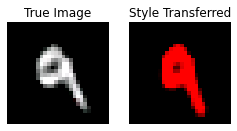

In [18]:
i=7
x_uncolored, y_label=encoded_image_test_set[i,:], labels_test[i]
x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
print(f"labels_test[i]:{labels_test[i]}")
x_trans_check= style_transfer_after_training(model_cinn_style_transfer,
                                             x_uncolored, y_label, 1, device=device)

### let's send x through the decoder
decoded_x_style_trans= decode_latent_vec(x_trans_check, ae_pretrained)
decoded_original= decode_latent_vec(x_uncolored, ae_pretrained)

#
plot_images(decoded_original, decoded_x_style_trans)

In [426]:
# Define a function to plot multiple images in a subplot
def plot_images_subplot(images, titles, num_plots=10, figsize=(12,4)):
    fig, axes = plt.subplots(2, num_plots, figsize=figsize)

    for i, (original, style_transferred) in enumerate(images):
        # Plot original images in the first row
        axes[0, i].imshow(original.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[0, i].set_title(titles[i][0], fontsize=11)
        axes[0, i].axis('off')

        # Plot style transferred images in the second row
        axes[1, i].imshow(style_transferred.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[1, i].set_title(titles[i][1], fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

1. Uncolored images to colored images

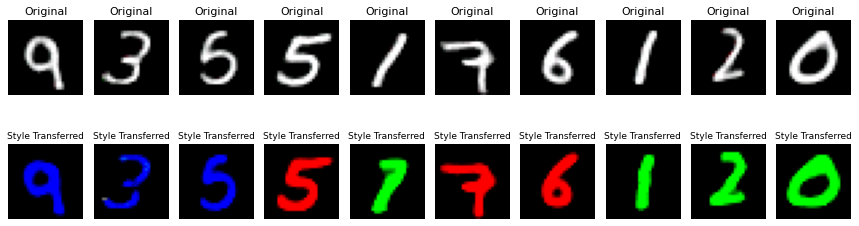

In [138]:
# Select 5 random indices from the test set
import random
random_indices = random.sample(range(len(encoded_image_test_set[:9000])), 10)

# Perform style transfer and plot for each selected image
images_to_plot = []
titles = []

for i in random_indices:
    x_uncolored, y_label = encoded_image_test_set[i], labels_test[i]
    x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
    source_style_label = 0 if y_label == 1 else 1
    label_target_style = 1 if y_label == 0 else 0

    x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                  x_uncolored, y_label, label_target_style, device=device)

    decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
    decoded_x_style_trans = decode_latent_vec(x_trans_check, ae_pretrained)

    images_to_plot.append((decoded_original, decoded_x_style_trans))
    titles.append(('Original', 'Style Transferred'))

    # Plot the original and style transferred images in a subplot
plot_images_subplot(images_to_plot, titles)

2. Colored to uncolored images

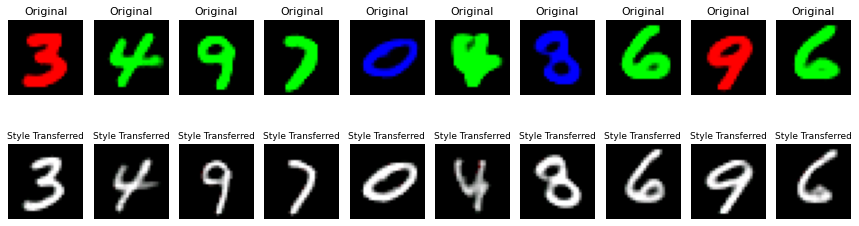

<Figure size 432x288 with 0 Axes>

In [123]:
### let;s check the other way around (colored to uncolored)
# Select 5 random indices from the test set
import random
random_indices =random.sample(range(-1,-5000,-1), 10)

# Perform style transfer and plot for each selected image
images_to_plot = []
titles = []

for i in random_indices:
    x_colored, y_label = encoded_image_test_set[i], labels_test[i]
    x_colored, y_label= x_colored.to(device), y_label.to(device)
    source_style_label = 0 if y_label == 1 else 1
    label_target_style = 1 if y_label == 0 else 0

    x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                  x_colored, y_label, label_target_style, device=device)

    decoded_original = decode_latent_vec(x_colored, ae_pretrained)
    decoded_x_style_trans = decode_latent_vec(x_trans_check, ae_pretrained)

    images_to_plot.append((decoded_original, decoded_x_style_trans))
    titles.append(('Original', 'Style Transferred'))

# Plot the original and style transferred images in a subplot
plot_images_subplot(images_to_plot, titles)
plt.savefig("colored_to_uncolored.png")

### OOD check

Uncolored emnist to colored emnist letters: 1. using AE trained on coloured and uncolored mnist digits and 2. Using AE trained on uncolored mnist and colored emnist

In [24]:
### Let's load the a pretrained AE, trained on uncolored alphabets(emnist) + colored mnist dataset
PATH_EMNIST_AE2_CHKPOINT=os.path.join(dataset_directory, 
                                    "checkpoint_AE_EMNIST_STYLE_TRANSFER.pth")

chkpoint_ae2= torch.load(PATH_EMNIST_AE2_CHKPOINT)

In [25]:
### load the pretrained AE 2 model
ae_pretrained_2 = chkpoint_ae2["model"]

# load the state dict to the model
ae_pretrained_2.load_state_dict(chkpoint_ae2["model_state_dict"])

<All keys matched successfully>

In [26]:
### load the uncolored emnist dataset

LETTERS_TEST_PATH=os.path.join(dataset_directory, 
                                    "test_images_letters.pt")
emnist_tensor= torch.load(LETTERS_TEST_PATH)### shape: torch.Size([20800, 28, 28]) and unnormalised
emnist_tensor = emnist_tensor/255. # normalise 


### I need to expand and then permute emnist_tensor

def resize_and_expand(uncolored_X):
  # Reshape uncolored images to (: 28, 28, 1)
  uncolored_X_resized = uncolored_X.reshape(-1, 28, 28, 1)
  
  # Expand single channel to three channels
  uncolored_X_expanded = np.repeat(uncolored_X_resized, 3, axis=-1)
  return uncolored_X_expanded


emnist_expanded= resize_and_expand(np.array(emnist_tensor))
emnist_expanded=torch.tensor(emnist_expanded)

#permute to be consistent with the AE
emnist_perm = emnist_expanded.permute(0,3,1,2)
emnist_expanded.shape, emnist_perm.shape

(torch.Size([20800, 28, 28, 3]), torch.Size([20800, 3, 28, 28]))

In [52]:
### create encodings
encoding_emnist_test= ae_pretrained.encoder(emnist_perm)#ae_pretrained_2.encoder(emnist_perm)
encoding_emnist_test_2= ae_pretrained_2.encoder(emnist_perm)

Let's check the style transfer

In [362]:
### let's also load colored mnist images
colored_digits_load = np.load('D:\\Desktop\\master_scientific_computing\\first_semester\\GNN\\project_repository\\GNN-exercises\\Project\\datasets\\colored_rgb_mnist_train.npz')
colored_digits= torch.tensor(colored_digits_load["images"])
colored_digits.shape

torch.Size([60000, 28, 28, 3])

In [363]:
colored_digits[0].shape

torch.Size([28, 28, 3])

In [377]:
encodings_colored_2= ae_pretrained_2.encoder(colored_digits.permute(0,3,1,2))
#decoded_colored_2 = ae_pretrained_2.decoder(encodings_colored_2)

#plt.imshow(colored_digits[0])

1. Uncolored emnist image to colored emnist using AE trained on coloured and uncolored mnist digits:

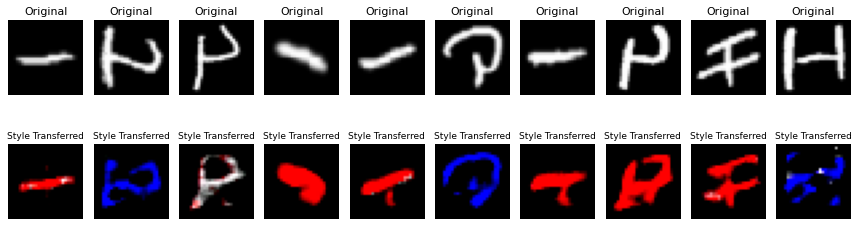

In [434]:
# Select 5 random indices from the test set
import random
random_indices = [8921, 7920, 7876, 7006, 6800, 5407, 6653, 7302, 5931, 7062]#random.sample(range(len(encoding_emnist_test[:9000])), 10)

# Perform style transfer and plot for each selected image
images_to_plot = []
titles = []

for i in random_indices:
    x_uncolored, y_label = encoding_emnist_test[i], labels_test[i]
    x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
    source_style_label = 0 if y_label == 1 else 1
    label_target_style = 1 if y_label == 0 else 0

    x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                  x_uncolored, y_label, label_target_style, device=device)

    # decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
    decoded_x_style_trans = decode_latent_vec(1.0* x_trans_check, ae_pretrained)

    images_to_plot.append((emnist_perm[i], decoded_x_style_trans))
    titles.append(('Original', 'Style Transferred'))

    # Plot the original and style transferred images in a subplot
plot_images_subplot(images_to_plot, titles)

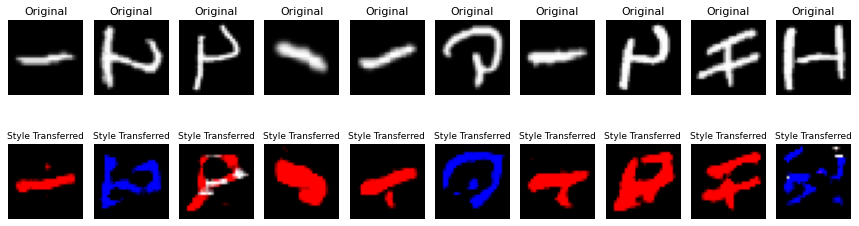

In [441]:
random_indices = [8921, 7920, 7876, 7006, 6800, 5407, 6653, 7302, 5931, 7062]#random.sample(range(len(encoding_emnist_test[:9000])), 10)

# Perform style transfer and plot for each selected image
images_to_plot = []
titles = []

for i in random_indices:
    x_uncolored, y_label = encoding_emnist_test[i], labels_test[i]
    x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
    source_style_label = 0 if y_label == 1 else 1
    label_target_style = 1 if y_label == 0 else 0

    x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                  x_uncolored, y_label, label_target_style, device=device)

    # decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
    decoded_x_style_trans = decode_latent_vec(1.8* x_trans_check, ae_pretrained)

    images_to_plot.append((emnist_perm[i], decoded_x_style_trans))
    titles.append(('Original', 'Style Transferred'))

    # Plot the original and style transferred images in a subplot
plot_images_subplot(images_to_plot, titles)

2. Uncolored emnist image to colored emnist using AE trained on uncolored emnist and uncolored mnist digits:

In [ ]:
### there is some issue with the code below. I need to look into it ASAP

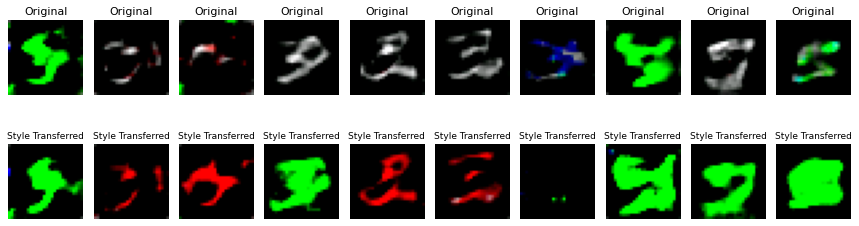

In [405]:
# # Select 5 random indices from the test set
# import random
# #random_indices = random.sample(range(len(encoding_emnist_test_2[:9000])), 10)

# # Perform style transfer and plot for each selected image
# images_to_plot = []
# titles = []

# for i in random_indices:
#     x_uncolored, y_label = encoding_emnist_test_2[i], labels_test[i]
#     x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
#     source_style_label = 0 if y_label == 1 else 1
#     label_target_style = 1 if y_label == 0 else 0

#     x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
#                                                   x_uncolored, y_label, label_target_style, device=device)

#     decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
#     decoded_x_style_trans = decode_latent_vec(x_trans_check, ae_pretrained)

#     images_to_plot.append((decoded_original, decoded_x_style_trans))
#     titles.append(('Original', 'Style Transferred'))

#     # Plot the original and style transferred images in a subplot
# plot_images_subplot(images_to_plot, titles)

### Let's explore the effects of linear scaling of the latent code z on the output

In [406]:
labels_test[0]

tensor([0.])

In [407]:
### sample from the latent space
sampled_z=model_cinn_style_transfer.sample(num_samples=1, cond=torch.tensor([1.]))

In [413]:
### let's decode the sample and plot it:
ae_pretrained.eval()
decoded_check = decode_latent_vec(sampled_z.detach(), ae_pretrained).detach()
decoded_check.shape

torch.Size([1, 3, 28, 28])

In [ ]:
# plt.imshow(decoded_check.squeeze().permute(1,2,0))

In [507]:
def plot_images_subplot_linear_scaling(images, titles, num_plots=10, figsize=(12,4)):
    fig, axes = plt.subplots(1, num_plots+1, figsize=figsize)
    for i, image in enumerate(images):
        # Plot style transferred images in the second row
        axes[i].imshow(image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
        axes[i].set_title(titles[i], fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

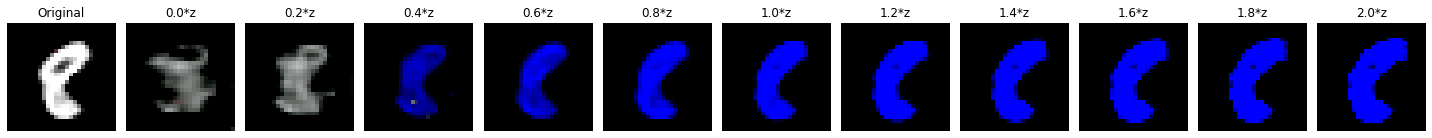

In [526]:
import random

random_index=random.randint(0,2000)

### create the image and corresponding label
x_uncolored, y_label = encoded_image_test_set[random_index], labels_test[random_index]
decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
source_style_label = 0 if y_label == 1 else 1
label_target_style = 1 if y_label == 0 else 0

x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                x_uncolored, y_label, 
                                                label_target_style, 
                                                device=device)

# Perform style transfer and plot for each selected image
images_to_plot = [decoded_original]
titles = ['Original']

scaling= [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

for scale_factor in scaling :

    scaled_z= scale_factor * x_trans_check

    decoded_x_style_trans = decode_latent_vec(scaled_z, 
                                              ae_pretrained)

    images_to_plot.append(decoded_x_style_trans)
    titles.append(f'{scale_factor}*z')

    # Plot the original and style transferred images in a subplot
plot_images_subplot_linear_scaling(images_to_plot, titles, num_plots=len(scaling),figsize=(20,10))


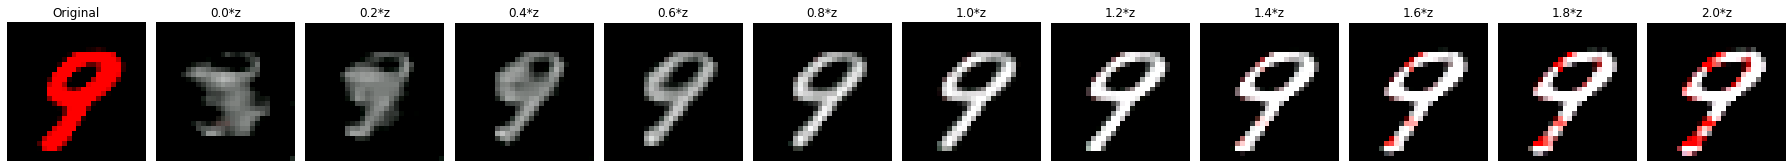

In [527]:
import random

random_index=-random.randint(0,2000)

### create the image and corresponding label
x_uncolored, y_label = encoded_image_test_set[random_index], labels_test[random_index]
decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
x_uncolored, y_label= x_uncolored.to(device), y_label.to(device)
source_style_label = 0 if y_label == 1 else 1
label_target_style = 1 if y_label == 0 else 0

x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                x_uncolored, y_label, 
                                                label_target_style, 
                                                device=device)

# Perform style transfer and plot for each selected image
images_to_plot = [decoded_original]
titles = ['Original']

scaling= [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

for scale_factor in scaling :

    scaled_z= scale_factor * x_trans_check

    decoded_x_style_trans = decode_latent_vec(scaled_z, 
                                              ae_pretrained)

    images_to_plot.append(decoded_x_style_trans)
    titles.append(f'{scale_factor}*z')

    # Plot the original and style transferred images in a subplot
plot_images_subplot_linear_scaling(images_to_plot, titles, num_plots=len(scaling),figsize=(25,10))

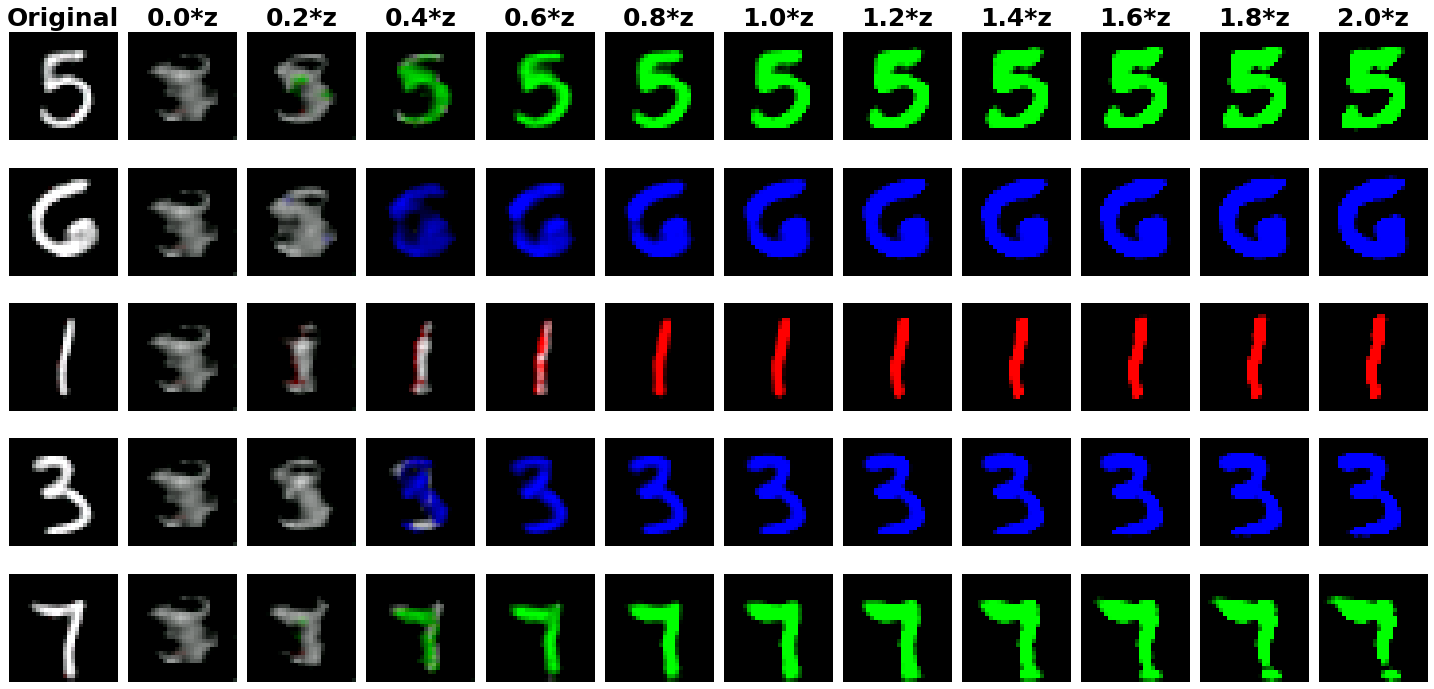

In [574]:
import random

def generate_and_plot_images_latent_scaling(encoded_image_test_set, labels_test, 
                                ae_pretrained, model_cinn_style_transfer, 
                                device, scaling= [0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0],
                                colorise=True):
    
    if colorise:
        rand_multiplier=1
    else:
        rand_multiplier=-1

    fig, axes = plt.subplots(5, len(scaling) + 1, figsize=(20, 10))

    # Plot titles only for the first row
    titles = ['Original']
    for scale_factor in scaling:
        titles.append(f'{scale_factor}*z')

    for row in range(5):
        random_index = rand_multiplier* random.randint(0, 2000)

        # Create the image and corresponding label
        x_uncolored, y_label = encoded_image_test_set[random_index], labels_test[random_index]
        decoded_original = decode_latent_vec(x_uncolored, ae_pretrained)
        x_uncolored, y_label = x_uncolored.to(device), y_label.to(device)
        source_style_label = 0 if y_label == 1 else 1
        label_target_style = 1 if y_label == 0 else 0

        x_trans_check = style_transfer_after_training(model_cinn_style_transfer,
                                                        x_uncolored, y_label,
                                                        label_target_style,
                                                        device=device)

        # Perform style transfer and plot for each selected image
        images_to_plot = [decoded_original]

        for i, scale_factor in enumerate(scaling):
            scaled_z = scale_factor * x_trans_check

            decoded_x_style_trans = decode_latent_vec(scaled_z, ae_pretrained)

            images_to_plot.append(decoded_x_style_trans)

        # Plot the images for this row
        for col, image in enumerate(images_to_plot):
            axes[row, col].imshow(image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
            if row == 0:  # Plot titles only for the first row
                axes[row, col].set_title(titles[col], fontsize=25, fontweight='bold')
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to generate and plot the images
generate_and_plot_images_latent_scaling(encoded_image_test_set, labels_test, ae_pretrained, model_cinn_style_transfer, device)


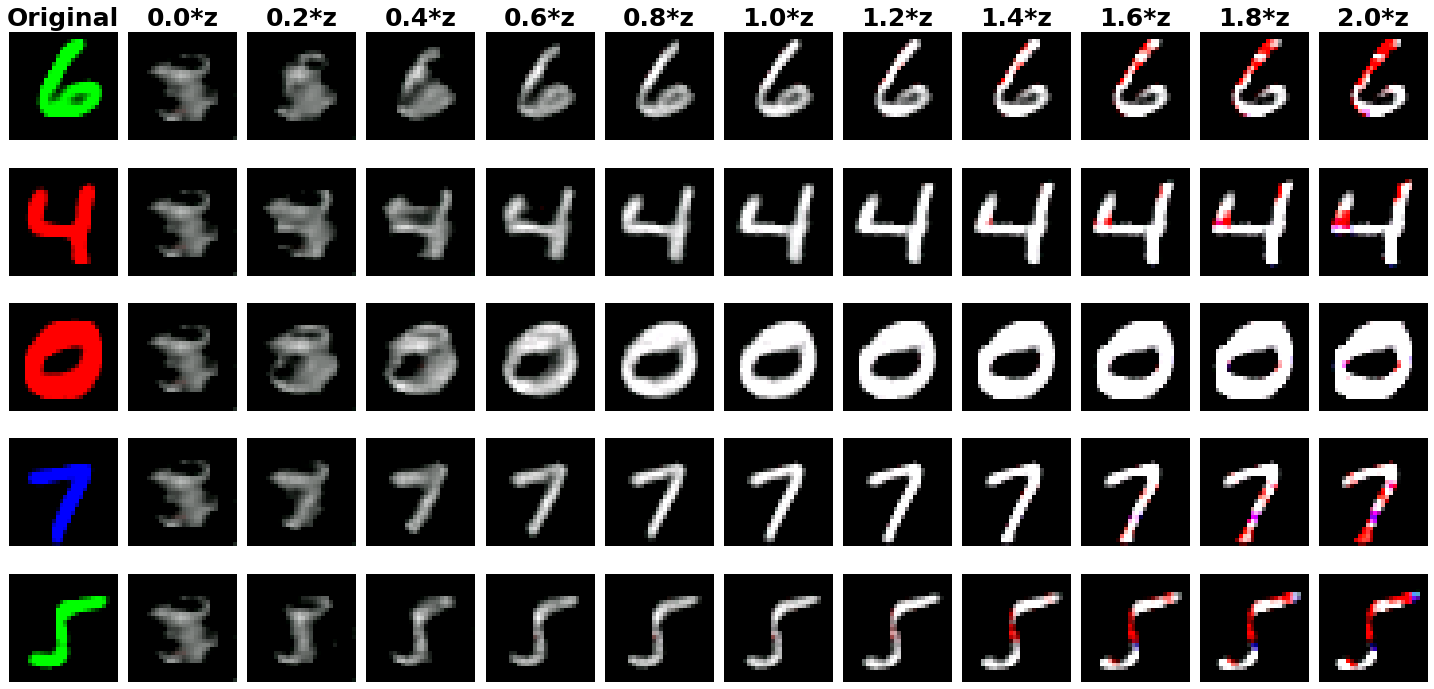

In [570]:
generate_and_plot_images_latent_scaling(encoded_image_test_set, labels_test, ae_pretrained, model_cinn_style_transfer, device, colorise=False)

### Encoded dataset for style transfer

In [402]:
# from datasets.custom_encoding_style_transfer import MixedMNIST,encodings_inputs_for_style_transfer,CustomEncodedStyleTransfer

# mixed_mnist_data=MixedMNIST(colored_rgb_mnist_dataset=colored_test_images,
#                             pre_trained_ae=ae_pretrained)

# mixed_image_dataset= mixed_mnist_data.mixed_images

# print(mixed_image_dataset.shape)
# print(mixed_mnist_data.mixed_images_labels.shape)

# ### let's create the encodings
# check_encodings= encodings_inputs_for_style_transfer(ae_model=ae_pretrained, data= mixed_image_dataset)

# print(check_encodings.shape)

In [403]:
# import matplotlib.pyplot as plt
# import torch

# # Assuming colored_test_images is your tensor
# first_5_images = mixed_image_dataset[:10]

# # Plot the first 5 images
# fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # Adjust figsize as needed
# for i in range(10):
#     img = first_5_images[i]
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f'Image {i+1}')

# plt.show()

In [404]:
# Assuming colored_test_images is your tensor
# first_5_images = mixed_image_dataset[60000:600010]

# # Plot the first 5 images
# fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # Adjust figsize as needed
# for i in range(10):
#     img = first_5_images[i]
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f'Image {i+1}')

# plt.show()